In [54]:
import os
import re
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.dates as mdates
%matplotlib inline

In [2]:
# set path
#os.chdir("/Users/Gabi/dev/Collibra")
os.chdir("/Users/Gabi/Documents/projects/SDR_Analysis")
data_path = os.getcwd() + "/data/"
os.chdir(os.getcwd() + "/src")

In [3]:
# read data
sdr_calls = 'sdr_calls.csv'
dat = pd.read_csv(data_path + sdr_calls)

In [214]:
# fix column names and add Fiscal Qt
dat.columns = [re.sub(r'\W+','', c) for c in dat.columns]
dat['qt'] = pd.PeriodIndex(dat.CreatedDate, freq = 'Q-SEP')


In [217]:
# number of incomplete and complete calls
dat.Outcome.value_counts()

Incomplete    22097
Complete       2356
Name: Outcome, dtype: int64

In [219]:
# number of incomplete and complete calls by QT
dat.groupby('qt').Outcome.value_counts()

qt      Outcome   
2016Q4  Incomplete     4560
        Complete        623
2017Q1  Incomplete    11799
        Complete       1002
2017Q2  Incomplete     5738
        Complete        731
dtype: int64

In [56]:
# SDRs in data
sdrs = dat.Assigned.drop_duplicates().tolist()
sdrs

['Ben Brendle',
 "Dan O'Brien",
 'David Iparraguirre',
 'Jonelle Miller',
 'Matt Tager',
 'Phil Arbeiter',
 'Tony Fitzgerald',
 'Trevor Gori',
 'Diane Vu']

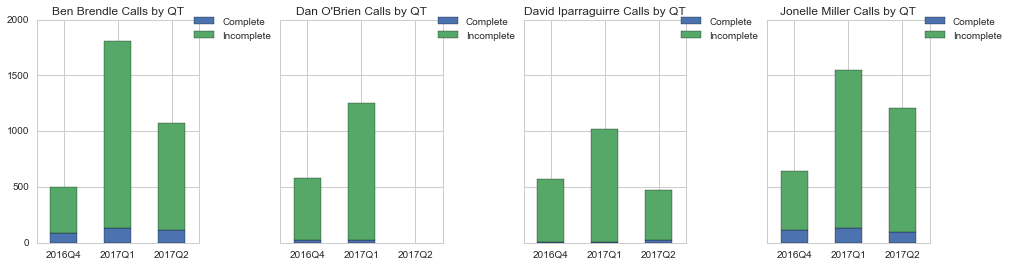

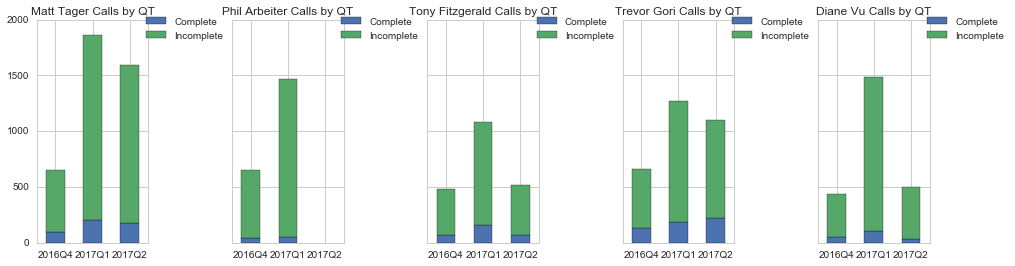

In [232]:
# Complete and Incomplete calls by Quarter and SDR
fig, axes = plt.subplots(nrows =1, ncols=4, figsize = (16,4), sharex=True, sharey=True)
fig.subplots_adjust(hspace=.8, wspace=.5)
for idx, s in enumerate(sdrs[0:4]):
    sdr_dat = dat[(dat.Assigned ==s)].groupby(['qt'])['Outcome'].value_counts().unstack()
    p_s = sdr_dat.plot(kind = 'bar', subplots=False, stacked = True, title = s + " Calls by QT", ax = axes[idx] )
    axes[idx].legend(bbox_to_anchor=(1.5, 1.05))
    labels = [item.get_text() for item in axes[idx].get_xticklabels()]
    axes[idx].set_xticklabels(labels, rotation = 0)
    axes[idx].set_xlabel("")
plt.show()

fig, axes = plt.subplots(nrows =1, ncols=5, figsize = (16,4), sharex=True, sharey=True)
fig.subplots_adjust(hspace=.8, wspace=.75)
for idx, s in enumerate(sdrs[4:]):
    sdr_dat = dat[(dat.Assigned ==s)].groupby(['qt'])['Outcome'].value_counts().unstack()
    p_s = sdr_dat.plot(kind = 'bar', subplots=False, stacked = True, title = s + " Calls by QT", ax = axes[idx])
    axes[idx].legend(bbox_to_anchor=(1.75, 1.05))
    axes[idx].set_xticklabels(labels, rotation = 0)
    axes[idx].set_xlabel("")
plt.show()


In [212]:
# SDR Total calls
sdr_total_calls = dat.groupby(['Assigned']).Outcome.count()
print sdr_total_calls.head()

Assigned
Ben Brendle           3381
Dan O'Brien           1828
David Iparraguirre    2073
Diane Vu              2429
Jonelle Miller        3404
Name: Outcome, dtype: int64


In [233]:
# percent of calls by SDR
sdr_res = dat.groupby(['Assigned']).Outcome.value_counts().reset_index()
sdr_res.rename(columns = {0:'Calls'}, inplace = True)
sdr_res.set_index('Assigned', inplace=True)
sdr_res['percent_calls'] = sdr_res.Calls/ sdr_total_calls

sdr_res.head()

,Outcome,Calls,percent_calls
Assigned,,,
Ben Brendle,Incomplete,3044,0.900325
Ben Brendle,Complete,337,0.099675
Dan O'Brien,Incomplete,1774,0.970460
Dan O'Brien,Complete,54,0.029540
David Iparraguirre,Incomplete,2031,0.979740


### Look at distribution of Complete & Incomplete Calls
 - is the data normally distributed?

In [ ]:
# split up data by call outcome
comp_calls = dat[dat.Outcome == 'Complete'].groupby('CreatedDate').Outcome.value_counts()
incomp_calls = dat[dat.Outcome == 'Incomplete'].groupby('CreatedDate').Outcome.value_counts()


In [246]:
#  avg complete calls daily = 20
comp_calls.describe()

count    119.000000
mean      19.798319
std        9.256770
min        1.000000
25%       13.500000
50%       20.000000
75%       26.000000
max       42.000000
dtype: float64

In [248]:
#  avg incomplete calls daily = 176
incomp_calls.describe()

count    122.000000
mean     181.122951
std       86.696734
min        1.000000
25%      130.250000
50%      176.000000
75%      252.000000
max      395.000000
dtype: float64

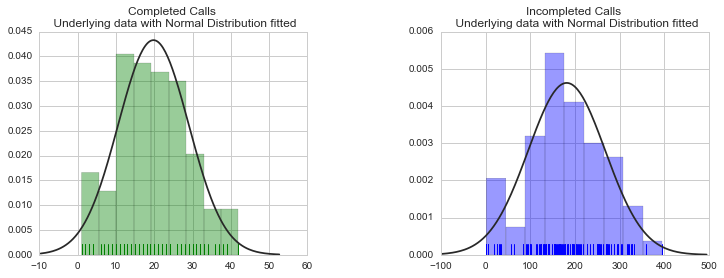

In [77]:
from scipy.stats import norm

# is the data normally distributed?
# Look at distribution of complete and incomplete calls - add fitted normal distribution
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize = (12,4))
fig.subplots_adjust(hspace=.5, wspace=.5)
sns.distplot(comp_calls, fit=norm, kde=False, rug = True, color= 'green', ax = ax1)
ax1.set_title('Completed Calls \n Underlying data with Normal Distribution fitted')

sns.distplot(incomp_calls, fit=norm, kde=False, rug = True, color= 'blue', ax = ax2)
ax2.set_title('Incompleted Calls \n Underlying data with Normal Distribution fitted')



### Is there a linear relationship between the number of completed calls and the number of incompleted calls?
* there s a slight correlation between # of calls complete and incomplete
* it doesnt really look like we can fit a good linear model here.. 

In [235]:
# there s a slight correlation between # of calls complete and incomplete
dat_outcomes.corr()

Outcome,Complete,Incomplete
Outcome,,
Complete,1.000000,0.602311
Incomplete,0.602311,1.000000


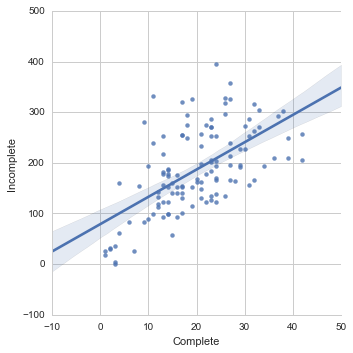

In [95]:
# plot data and linear regression model fit
sns.lmplot(x="Complete", y="Incomplete", data=dat_outcomes)

### What if the data is grouped by quarter  - is there a correlation between the number of complete and incomplete calls?

In [109]:
qt_outcomes = dat.groupby(['CreatedDate','qt']).Outcome.value_counts().unstack()
qt_outcomes = qt_outcomes.reset_index()

In [251]:
qt_outcomes.head()

Outcome,CreatedDate,qt,Complete,Incomplete
0,1/10/17,2017Q2,23.0,135.0
1,1/11/17,2017Q2,14.0,123.0
2,1/12/17,2017Q2,24.0,139.0
3,1/13/17,2017Q2,17.0,155.0
4,1/17/17,2017Q2,21.0,197.0


In [250]:
qt_outcomes.corr()

Outcome,Complete,Incomplete
Outcome,,
Complete,1.000000,0.602311
Incomplete,0.602311,1.000000


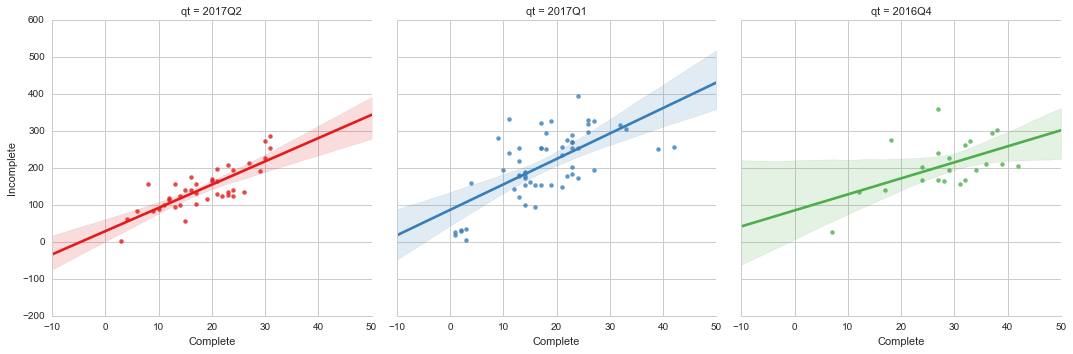

In [111]:
# plot complete vs incomplete by quarter
p_lm = sns.lmplot(x="Complete", y="Incomplete", col ='qt', hue = 'qt',data=qt_outcomes, palette="Set1", fit_reg= True)
plt.show()


In [260]:
# group data by qt and sdr
sdr_outcomes = dat.groupby(['qt','Assigned']).Outcome.value_counts().unstack()
sdr_outcomes = sdr_outcomes.reset_index()
sdr_outcomes.head()


Outcome,qt,Assigned,Complete,Incomplete
0,2016Q4,Ben Brendle,84,418
1,2016Q4,Dan O'Brien,26,552
2,2016Q4,David Iparraguirre,11,564
3,2016Q4,Diane Vu,53,386
4,2016Q4,Jonelle Miller,115,531


In [262]:
sdr_outcomes.set_index('Assigned').corr()

Outcome,Complete,Incomplete
Outcome,,
Complete,1.000000,0.468946
Incomplete,0.468946,1.000000


In [266]:
dat[dat.Assigned=='David Iparraguirre'].groupby(['qt']).Outcome.value_counts().unstack()

Outcome,Complete,Incomplete
qt,,
2016Q4,11,564
2017Q1,5,1018
2017Q2,26,449


In [256]:
# correlation for each sdr 
sdr_outcomes.groupby(['Assigned']).corr()

Outcome                        Complete  Incomplete
Assigned           Outcome                         
Ben Brendle        Complete    1.000000    0.962417
                   Incomplete  0.962417    1.000000
Dan O'Brien        Complete    1.000000    1.000000
                   Incomplete  1.000000    1.000000
David Iparraguirre Complete    1.000000   -0.839811
                   Incomplete -0.839811    1.000000
Diane Vu           Complete    1.000000    0.928073
                   Incomplete  0.928073    1.000000
Jonelle Miller     Complete    1.000000    0.304336
                   Incomplete  0.304336    1.000000
Matt Tager         Complete    1.000000    0.999445
                   Incomplete  0.999445    1.000000
Phil Arbeiter      Complete    1.000000    1.000000
                   Incomplete  1.000000    1.000000
Tony Fitzgerald    Complete    1.000000    0.998142
                   Incomplete  0.998142    1.000000
Trevor Gori        Complete    1.000000    0.718810
                   Incomplete  0.718810    1.000000

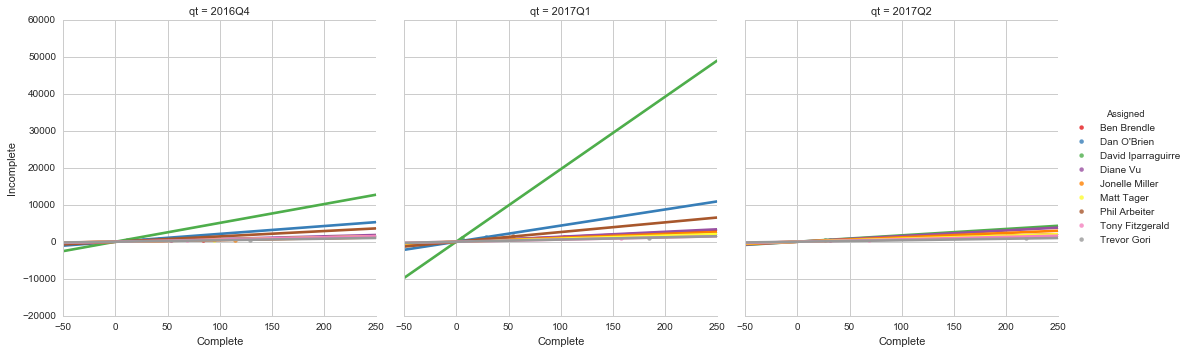

In [147]:
p_lm = sns.lmplot(x="Complete", y="Incomplete", col ='qt', hue = 'Assigned',data=sdr_outcomes, palette="Set1")
plt.show()

In [252]:
sdr_qt = dat.groupby(['qt','Assigned']).Outcome.value_counts().reset_index()
sdr_qt.rename(columns= {0:'Total'}, inplace = True)
sdr_qt.head(8)

,qt,Assigned,Outcome,Total
0,2016Q4,Ben Brendle,Incomplete,418
1,2016Q4,Ben Brendle,Complete,84
2,2016Q4,Dan O'Brien,Incomplete,552
3,2016Q4,Dan O'Brien,Complete,26
4,2016Q4,David Iparraguirre,Incomplete,564
5,2016Q4,David Iparraguirre,Complete,11
6,2016Q4,Diane Vu,Incomplete,386
7,2016Q4,Diane Vu,Complete,53


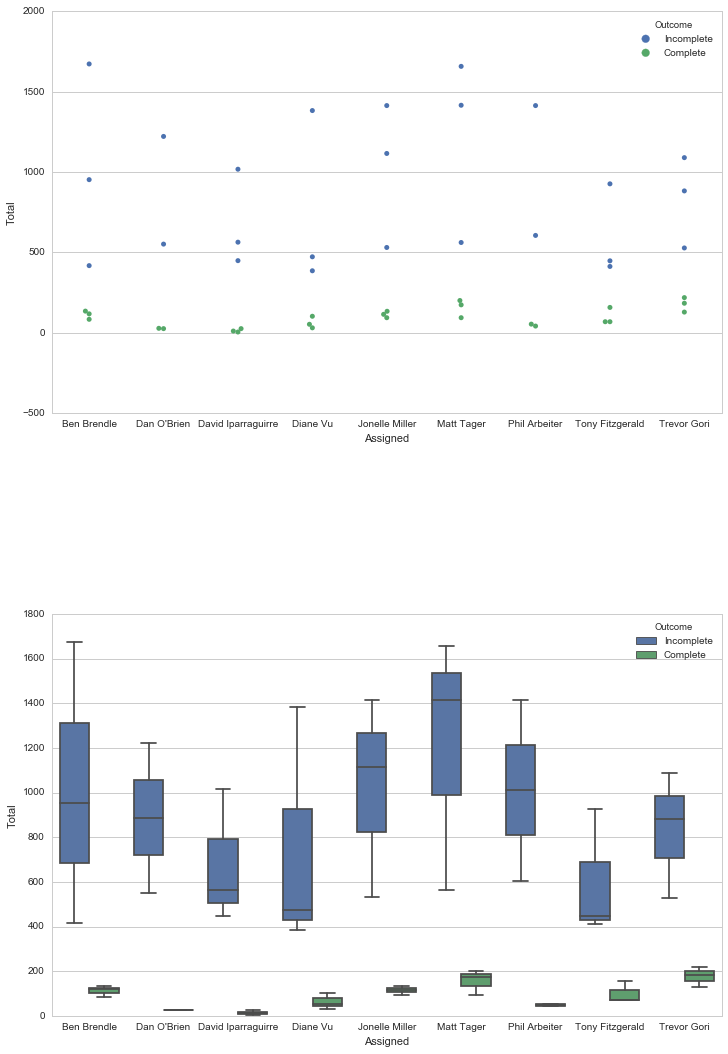

In [254]:
# scatter plot of call by outcome for each SDR 
# boxplot
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(12,18))
fig.subplots_adjust(hspace=.5, wspace=.5)
sns.swarmplot(x="Assigned", y="Total", hue="Outcome", data=sdr_qt, ax = ax1)
sns.boxplot(x="Assigned", y="Total", hue="Outcome", data=sdr_qt, ax = ax2)


In [270]:
import numpy as np

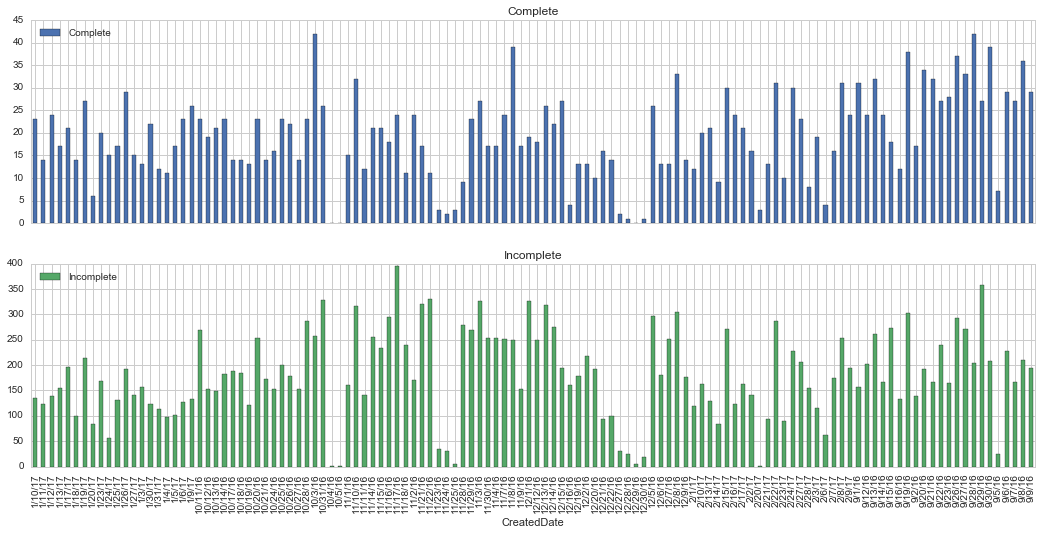

In [274]:
myFmt = mdates.DateFormatter('%Y-%m')
fig, ax = plt.subplots(nrows =1, ncols=1, figsize = (18,8))
p1 = dat.groupby(['CreatedDate'])['Outcome'].value_counts().unstack().plot(ax =ax, subplots= True, kind = 'bar', sharex=True)
#ax.xaxis_date()
# ax.format_xdata = mdates.DateFormatter('%Y-%m')
start, end = ax.get_xlim()
ax.xaxis.set_major_formatter(myFmt)
ax.set_xticklabels(np.arange(start, end, 15))
plt.show()

In [ ]:
myFmt = mdates.DateFormatter('%Y-%m')
max(labels)
np.arange(start, end, 2)

0
1
2


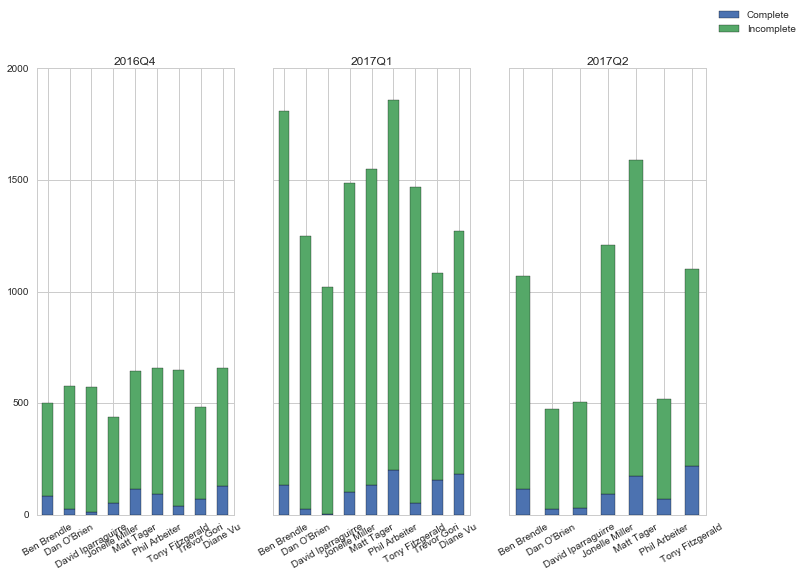

In [310]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize = (12,8), sharey=True)
for idx, elem in enumerate(dat.qt.drop_duplicates()):
    print idx
    temp = dat[dat.qt == elem].groupby(['qt','Assigned']).Outcome.value_counts()
    temp.sort_values(ascending=False)
    pp = temp.unstack().plot(kind ='bar', stacked = True, title = elem, subplots=False, ax = axes[idx])
    axes[idx].legend().set_visible(False)
    axes[idx].set_xticklabels(sdrs, rotation = 30)
    axes[idx].set_xlabel("")
pp.legend(bbox_to_anchor=(1.5, 1.15))
plt.show()
